# Figure 5S1 Loback et al. 

LMS in other subjects.

Note that these results may differ slightly from those reported in the paper, due to different (random) partitioning of the data into testing vs. validation sets. This variance does not change the conclusions of the paper, and running many replicas was computationally prohibative. 

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add local scripts to path
import os,sys
sys.path.insert(0,os.path.abspath("./"))
import neurotools

# Set up cache
from neurotools.jobs.initialize_system_cache import initialize_caches,cache_test
PYCACHEDIR = os.path.abspath('./')
CACHENAME  = 'PPC_cache'
from neurotools.tools import ensure_dir
ensure_dir(PYCACHEDIR+os.sep+CACHENAME)
initialize_caches(
    level1  = PYCACHEDIR,
    force   = False,
    verbose = False,
    CACHE_IDENTIFIER = CACHENAME)

# Import libraries
from neurotools.nlab import *
import ppc_data_loader

# Set this to the location of the PPC data on your machine
ppc_data_loader.path = '/home/mer49/Dropbox (Cambridge University)/Datasets/PPC_data/'
from ppc_data_loader   import *
from ppc_trial         import *

# Configure Numpy
np.seterr(all='ignore')
np.set_printoptions(precision=3)
import warnings
warnings.filterwarnings("ignore","scipy")
print('Numpy configured')

# Configure Matplotlib
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
TEXTWIDTH = 5.62708
matplotlib.rcParams['figure.figsize'] = (TEXTWIDTH, TEXTWIDTH/sqrt(2))
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore",category=MatplotlibDeprecationWarning)
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
matplotlib.rc('font' , size   =SMALL_SIZE ) # controls default text sizes
matplotlib.rc('axes' , titlesize=MEDIUM_SIZE) # fontsize of the axes title
matplotlib.rc('axes' , labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
matplotlib.rc('xtick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('ytick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('legend', fontsize =SMALL_SIZE ) # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rc('lines' , solid_capstyle='round')
plt.rcParams['image.cmap'] = 'parula'
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=[BLACK,RUST,TURQUOISE,OCHRE,AZURE,MAUVE])
matplotlib.rc('savefig',dpi=240)
print('Matplotlib configured')

# Fixed random seed was added after publication
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Numpy configured
Matplotlib configured


In [10]:
use = [(1,[1, 4, 5, 6, 7, 10, 14]),
     (3,[ 1,  2,  4,  6,  7,  8,  9, 10, 11, 12]),
     (3,[13, 14, 15, 16, 17, 18, 19, 20, 21, 22]),
     (4,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]),
     (5,[6, 7, 8, 9, 10, 11, 12])]

KINEMATICS_TO_PREDICT = [1]

In [11]:
from ppc_analysis import kininfo,add_constant,polar_error_degrees

# Number of sessions used to initialize LMS
PRETRAIN = 1
# K-fold crossvalidation for same-day predictions
NXVAL    = 10

@memoize
def prepare_data(animal,sessions,predict,PRETRAIN,NXVAL):
    '''
    Retrieve and prepare data for LMS analysis. 
    
    Parameters
    ----------
    animal: int
        Which subject to use
    session: list of ints
        Which session IDs to use
    predit: int
        Which kinematic variable to use. See hte `kininfo` variable.
        0:X, 1:Y, 2:dX, 3:dY, 4: head direction
    PRETRAIN: int
        Number of sessions to train on to initialize LMS
    NXVAL: int
        K-fold crossvalidation
        
    Returns
    -------
    Xtnt: list
        List of neural data for trials for initial trianing. 
        Each trial is NSAMPLES x NNEURONS+1 in shape, where
        a constant feature has been appended to the dF/F 
        Calcium signals. 
    Ytnt: list
        List of kinematic data for trials for initial training. 
    Xtst: list
        Neural data for testing trials.
    Ytst: list
        Kinematic data for testing trials
    sameday: dict
        Dictionary mapping session numbers to
        decoding accuracy results. Relevant Keys are:
            e: the signed decoding errors under crossvalidation
            mabse: the mean absoulte error
            yh: the predicted kinematic values
    '''
    # Get units in common over given sessions
    units,uidxs = get_units_in_common(animal,sessions)
    # Collect pretraining data
    Xtnt = []
    Ytnt = []
    for s in sessions[:PRETRAIN]:
        f  = get_dFF(animal,s)[:,units]
        k  = kininfo[predict]['get'](animal,s)
        Xtnt += [add_constant(x) for x in extract_in_trial(f,animal,s)]
        Ytnt += extract_in_trial(k,animal,s)
    # Collect testing data
    # Also get single-day performance
    Xtst = []
    Ytst = []
    sameday = {s:{} for s in sessions[PRETRAIN:]}
    for s in sessions[PRETRAIN:]:
        f  = get_dFF(animal,s)[:,units]
        k  = kininfo[predict]['get'](animal,s)
        x  = [add_constant(x) for x in extract_in_trial(f,animal,s)]
        y  = extract_in_trial(k,animal,s)
        Xtst += x
        Ytst += y
        # Also get single-day performance
        yd = trial_crossvalidated_least_squares(x,y,NXVAL,shuffle=True)[1]
        ed = np.concatenate(y) - yd
        ad = mean(abs(ed))
        sameday[s]['e'] = ed
        sameday[s]['mabse'] = ad
        sameday[s]['yh'] = yd
    return Xtnt,Ytnt,Xtst,Ytst,sameday

### Compute and cache prepared data

**(skip this step if disk caching is not enabled!)**

In [12]:
if 'hierarchical_cacher' in str(memoize):
    nunits = {}
    for a,ss in use:
        print(a,ss)
        for k in KINEMATICS_TO_PREDICT:
            Xtnt,Ytnt,Xtst,Ytst,sameday = prepare_data(a,ss,k,PRETRAIN,NXVAL)
        print('%d neurons'%(Xtnt[0].shape[1]-1))
        nunits[a,tuple(ss)] = Xtnt[0].shape[1]-1
    print('Done')

1 [1, 4, 5, 6, 7, 10, 14]
101 neurons
3 [1, 2, 4, 6, 7, 8, 9, 10, 11, 12]
114 neurons
3 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
98 neurons
4 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
143 neurons
5 [6, 7, 8, 9, 10, 11, 12]
112 neurons
Done


# LMS algorithm with limits on the weight changes

In [13]:
def run_LMS(X,Y,w0=None,rate=1,reg=1e-16,normalized=False,delta=None,clip=None):
    '''
    Run the LMS algorithm 
    s
    Parameters
    ----------
    X: array-like; Nsamples x Nfeatures
        Independent (input) variables
    Y: array-like; Nsamples x Noutputs
        Dependent (output) variables
    
    Other Parameters
    ----------------
    w0: array-like
        Initial parameter weighers
    rate: scalar, default 1
        Learning rate
    reg: scalar, default 1e-12
        L2 regularization penalty to shrink weight
    normalized: bool, default True
        Whether to run the Normalized LMS
    delta: positive scalar, default is None
        (This is not used in the paper.)
        If not `None`, we will report not the true weights
        but the a process that tracks the true rates, with 
        a limit of `delta` change/timestep. In theory,
        this would correspond to a slow process (e.g. 
        synaptic size change), while the actual fast changes
        in synaptic strength are handled by some other 
        process.
    clip: positive scalar, default is None
        (This is no longer used in the paper)
        If not `None`, then weight changes will be limited
        to be no larger than this value (up to floating point
        accuracy). This is important for enforcing an upper
        bound on the rate of weight change. 

    Returns
    -------
    all_w:
        Weights over time
    all_e;
        Errors over time
    all_yh:
        Predicted kinematics over time
    '''
    X = np.array(X)
    Y = np.array(Y)
    if len(Y.shape)==1:
        Y = array([Y]).T
    rate  = np.float32(rate)
    if not delta is None:
        delta = np.abs(np.float32(delta))
    if not clip  is None:
        clip  = np.abs(np.float32(clip))
    Nsamples   = Y.shape[0]
    Nfeatures  = X.shape[1]
    Nkinematic = Y.shape[1]
    # Initial weights
    w = zeros((Nfeatures,Nkinematic)) if w0 is None\
        else np.array(w0).reshape((Nfeatures,Nkinematic))
    # Tracking weights
    u = w.copy()
    # Store a history of weights, errors, and decoder estiamtes
    all_w  = zeros((Nsamples+1,Nfeatures,Nkinematic))
    all_e  = zeros((Nsamples,Nkinematic))
    all_yh = zeros((Nsamples,Nkinematic))
    all_w[0] = w
    # Shrinkage penalty
    λ = exp(-reg)
    # Run LMS algorithm
    for t in range(Nsamples):
        x    = X[t:t+1] # 1×Nfeat; intput features
        y    = Y[t:t+1] # 1×Nkine; decoded kinematics
        yh   = x @ w    # 1×Nfeat∙Nfeat×Nkine; prediction
        e    = y-yh     # 1×Nkine; errors
        # 1x1; weight update strength (normalized)
        α    = (rate/x @ x.T) if normalized else rate 
        dw   = (α*x.T@ e) # Nfeat×1∙1×Nkine; weight update
        # L2 regularize (not applied to DC parameter)
        dw[:-1] = (w[:-1]+dw[:-1])*λ-w[:-1]
        # Clipped weight updates
        w   += dw if clip is None else np.clip(dw,-clip,clip)
        # Clipped tracking
        u = w if delta is None else u+np.clip(w-u,-delta,delta)
        all_w [t+1] = u
        all_e [t  ] = e
        all_yh[t  ] = yh
        if not clip is None:
            assert(np.all(np.abs(all_w[t+1]-all_w[t])<=clip*(1+1e-7)))
        if not delta is None:
            assert(np.all(np.abs(all_w[t+1]-all_w[t])<=delta*(1+1e-7)))
    if not delta is None:
        all_yh = np.sum(X[:,:,None] * all_w[:-1],axis=1)
        all_e  = Y - all_yh
    all_w = all_w[1:]

    return all_w,all_e,all_yh

def test_LMS_summary(X,Y,w0,rate,polar_error=False,reg=1e-16,clip=None,delta=None):
    '''
    Test least mean-squares, returning the weights as well as the
    statistical summary information. 
    
    Parameters
    ----------
    X: np.array
        NSAMPLES x NNEURONS+1 neural data. 
        Last feature should be a constant offset.
    Y: np.array
        NSAMPLES x NKINEMATICS kinematic data.
    w0: np.array
        NNEURONS+1 x 1 vector of initial decoding weights
    rate: float
        Learning rate
        
    Other Parameters
    ----------------
    polar_error: bool, default False
        Whether to use polar error (for head direction)
    reg: float, default 1e-12
        L2 regularization of weights toward zero
    clip: positive scalar, default is None
        If not `None`, then weight changes will be limited
        to be no larger than this value (up to floating point
        accuracy). This is important for enforcing an upper
        bound on the rate of weight change. 
    delta: positive scalar, default is None
        (This is not used in the paper.)
        
    Returns
    -------
    dict: results, with the following keys
        RMSE:  root-mean-squared prediction error
        MABSE: mean absolute prediction error
        RMSD:  root mean squared weight change between samples
        MABSD: mean absolute change in weights between samples
        MAXD:  maximum absolute change in weights between samples
    '''
    X,T = np.array(X),np.array(Y)
    if len(Y.shape)==1: Y=array([Y]).T
    assert type(rate) is not list
    w,e,yh  = run_LMS(X,Y,w0,
        rate       = rate,
        reg        = reg,
        normalized = False,
        delta      = delta,
        clip       = clip)
    RMSE, MABSE = polar_error_degrees(Y,yh) if polar_error else\
                  np.sqrt(np.mean(np.abs(e)**2)),np.mean(np.abs(e))
    dw    = np.diff(w[:,:,0],axis=0)
    RMSD  = np.sqrt(np.mean(dw**2))
    MABSD = np.mean(np.abs(dw))
    MAXD  = np.max (np.abs(dw))
    if not clip is None:
        # Validate that weight-change limit was applied
        if np.any(np.abs(dw)>clip*(1+1e-6)):
            raise ValueError('!: some Δw larger than clip value of %f!!!!'%clip)
        assert(MAXD<clip*(1+1e-6))
        assert(MABSD<clip*(1+1e-6))
    return {
        'RMSE' :RMSE,
        'MABSE':MABSE,
        'RMSD' :RMSD,
        'MABSD':MABSD,
        'MAXD' :MAXD
    }

# Will need duration (in samples) of each session
@memoize
def get_session_lengths(animal,sessions,PRETRAIN):
    slens = [len(concatenate(extract_in_trial(get_dFF(animal,s)[:,0],animal,s))) for s in sessions]
    edges = array([0]+list(cumsum(slens[PRETRAIN:])-2))
    return slens, edges

@memoize
def test_constrained_LMS(animal,sessions,predict,rate,delta,PRETRAIN=1,NXVAL=10,reg=0.0):
    Xtnt,Ytnt,Xtst,Ytst,sameday = prepare_data(animal,sessions,predict,PRETRAIN,NXVAL)
    Xtrain = concatenate(Xtnt)
    Ytrain = concatenate(Ytnt)
    Xtest  = concatenate(Xtst)
    Ytest  = concatenate(Ytst)
    # Concatenated baseline
    yc = trial_crossvalidated_least_squares(Xtst,Ytst,NXVAL,shuffle=True,reg=reg)[1]
    ec = Ytest - yc
    ac = mean(abs(ec))
    # Pretrain baseline
    w0 = reglstsq(Xtrain,Ytrain,reg=1e-2)
    y0 = Xtest @ w0
    e0 = Ytest - y0.ravel()
    a0 = mean(abs(ec))
    # LMS performance
    w,e,yh = run_LMS(Xtest,Ytest,w0,rate=rate,clip=delta)
    return {
        'Xtest':Xtest,
        'Ytest':Ytest,
        'sameday':sameday,
        'w' :squeeze(w),     # Weights while running LMS
        'e' :squeeze(e),     # Online 1-step prediction error using LMS
        'e0':squeeze(e0),    # error without LMS updating
        'ec':squeeze(ec),    # error using crossvalidated concatenated decoder
        'y' :squeeze(Ytest), # testing data
        'yh':squeeze(yh),    # predicted testing data with LMS updates
        'y0':squeeze(y0)}    # predicted testing data without LMS updates (pretrain only)

def summarize_LMS_result(animal,sessions,result,verbose=True):
    slens, edges           = get_session_lengths(animal,sessions,PRETRAIN)
    weights                = result['w']
    end_of_session_weights = weights[edges,:-1] #exclude constant weight
    inter_session_Δweights = diff(end_of_session_weights,axis=0)
    days                   = [daymap[animal,s] for s in sessions]
    Δdays                  = diff(days)[PRETRAIN-1:]
    Δweight_per_Δday       = inter_session_Δweights/Δdays[:,None]
    MABS_Δw_per_Δday       = mean(abs(Δweight_per_Δday))
    MABSW                  = mean(abs(weights))
    MABS_Δw_pct_per_day    = mean(MABS_Δw_per_Δday)/MABSW*100
    ec = mean(abs(result['ec']))
    er = mean(abs(result['e']))
    variance  = var(result['y'])
    residuals = var(result['e'])
    explained = variance-residuals
    pctΔvlms  = 100*explained/variance
    variance  = var(result['y'])
    residuals = var(result['ec'])
    explained = variance-residuals
    pctΔvcat  = 100*explained/variance
    variance  = var(result['y'])
    residuals = var(result['e0'])
    explained = variance-residuals
    pctΔvfix  = 100*explained/variance
    relperf   = (pctΔvlms-pctΔvfix)/(pctΔvcat-pctΔvfix)*100
    if verbose:
        print('Mouse %s sessions %s'%(animal,sessions))
        print(' %d units'%weights.shape[1])
        print(' Average    weight change is %0.2f%% per day'%MABS_Δw_pct_per_day)
        print(' Concatenated error level is %2f'%ec)
        print(' LMS          error level is %2f'%er)
        print(' Relative LME error level is %3.1f'%((er-ec)/ec*100))
        print(' %% explained variance %0.2f LMS'%pctΔvlms)
        print(' %% explained variance %0.2f Concat.'%pctΔvcat)
        print(' %% explained variance %0.2f Fixed'%pctΔvfix)
        print(' Relative performance %0.2f%%'%relperf)
    return relperf,MABS_Δw_pct_per_day

## Compute (or retrieve) LMS filtering results

In [14]:
# Limit on the amount of weight change
# (Set to "None" for no limit)
delta    = None

# Learning rate
# Faster can be more accurate (if stable)
# but leads to larger weight changes per day
rate     = 4e-4
#rate     = 3e-4

# Number of sessions used to train the fixed decoder
# We're limited in sessions so we use only the first session
# For this figure. 
PRETRAIN = 1

# Pre-fetch all the results
# (these should be pulled from the disk cache, if cachingis working)

weightchange_results = {}
for animal, sessions in use:
    for predict in KINEMATICS_TO_PREDICT:
        key = (animal,tuple(sessions),predict)
        result = test_constrained_LMS(animal,sessions,predict,rate,delta,PRETRAIN,NXVAL)
        rel_accuracy,MABS_Δw_pct_per_day = \
            summarize_LMS_result(animal,sessions,result)
        result['rate'               ] = rate
        result['MABS_Δw_pct_per_day'] = MABS_Δw_pct_per_day
        result['rel_accuracy'       ] = rel_accuracy #% of cat performance
        weightchange_results[key] = result

Mouse 1 sessions [1, 4, 5, 6, 7, 10, 14]
 102 units
 Average    weight change is 8.82% per day
 Concatenated error level is 0.721076
 LMS          error level is 0.748932
 Relative LME error level is 3.9
 % explained variance 74.32 LMS
 % explained variance 75.77 Concat.
 % explained variance 65.97 Fixed
 Relative performance 85.13%
Mouse 3 sessions [1, 2, 4, 6, 7, 8, 9, 10, 11, 12]
 115 units
 Average    weight change is 9.75% per day
 Concatenated error level is 0.652183
 LMS          error level is 0.671664
 Relative LME error level is 3.0
 % explained variance 77.71 LMS
 % explained variance 79.04 Concat.
 % explained variance 63.28 Fixed
 Relative performance 91.55%
Mouse 3 sessions [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
 99 units
 Average    weight change is 11.45% per day
 Concatenated error level is 0.808976
 LMS          error level is 0.866298
 Relative LME error level is 7.1
 % explained variance 60.48 LMS
 % explained variance 64.33 Concat.
 % explained variance 41.28 Fix

## Prepare data for plotting

In [15]:
# Sample rate and how much to plot
FS      = 5.3
dt      = 60*1.5
SMOOTH  = int(FS*60*5)
RESULTS = weightchange_results
SMOOTHED_RESULTS = {}
def avg_error(e):
    N = len(e)
    e = median_filter(e,SMOOTH,mode='valid')
    return interp1d(linspace(0,N-1,len(e)),e)(arange(N))
for k,(animal, sessions) in enumerate(use):
    sessions = tuple(sessions)
    slens, edges = get_session_lengths(animal,sessions,PRETRAIN)
    for predict in KINEMATICS_TO_PREDICT:
        key = animal,sessions,predict
        # Get reconstruction errors
        e      = abs(RESULTS[key]['e' ]) # LMS
        e0     = abs(RESULTS[key]['e0']) # No learning
        ec     = abs(RESULTS[key]['ec']) # Concatenated
        eq     = concatenate([RESULTS[key]['sameday'][s]['e'] for s in sessions[PRETRAIN:]])
        # Smooth curves in preparation for plotting
        e0 = cat([avg_error(e0[edges[i]:edges[i+1]]) for i in range(len(sessions)-PRETRAIN)])
        ec = cat([avg_error(ec[edges[i]:edges[i+1]]) for i in range(len(sessions)-PRETRAIN)])
        e  = cat([avg_error(e [edges[i]:edges[i+1]]) for i in range(len(sessions)-PRETRAIN)])
        eq = cat([avg_error(eq[edges[i]:edges[i+1]]) for i in range(len(sessions)-PRETRAIN)])
        SMOOTHED_RESULTS[key]={}
        SMOOTHED_RESULTS[key]['e0']=e0 # No learning
        SMOOTHED_RESULTS[key]['ec']=ec # Concatenated
        SMOOTHED_RESULTS[key]['eq']=eq # Same-day
        SMOOTHED_RESULTS[key]['e' ]=e  # LMS

## Render figure 

1 (1, 4, 5, 6, 7, 10, 14)
3 (1, 2, 4, 6, 7, 8, 9, 10, 11, 12)
3 (13, 14, 15, 16, 17, 18, 19, 20, 21, 22)
4 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
5 (6, 7, 8, 9, 10, 11, 12)


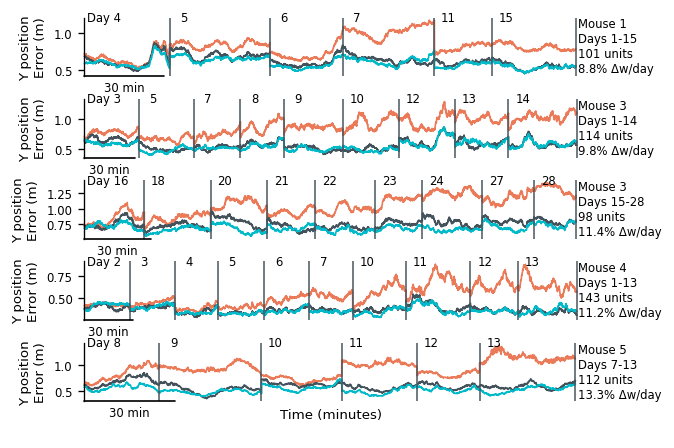

In [16]:
try:
    nunits
except:
    nunits = {(1, (1, 4, 5, 6, 7, 10, 14)): 101,
     (3, (1, 2, 4, 6, 7, 8, 9, 10, 11, 12)): 114,
     (3, (13, 14, 15, 16, 17, 18, 19, 20, 21, 22)): 98,
     (4, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)): 134,
     (5, (6, 7, 8, 9, 10, 11, 12)): 112}

figure(figsize=(TEXTWIDTH,0.75*5))
axs = {}
for k,(animal, sessions) in enumerate(use):
    axs[k] = subplot(5,1,k+1)
    sessions = tuple(sessions)
    slens, edges = get_session_lengths(animal,sessions,PRETRAIN)
    print(animal,sessions)
    for predict in KINEMATICS_TO_PREDICT:
        key = animal,sessions,predict
        t1 = RESULTS[key]['y'].shape[0]//2
        t2 = t1 + int(dt*FS)
        tt = arange(t1,t2)/FS
        # Reconstruction errors
        e     = SMOOTHED_RESULTS[key]['e' ] # LMS
        e0    = SMOOTHED_RESULTS[key]['e0'] # No learning
        ec    = SMOOTHED_RESULTS[key]['ec'] # Concatenated
        eq    = SMOOTHED_RESULTS[key]['eq'] # Same-day 
        T     = e0.shape[0]
        tt    = arange(T)/FS/60
        plot(tt[:edges[-1]],e0,lw=1,label='No retraining',color=RUST     ,clip_on=False)
        plot(tt[:edges[-1]],e ,lw=1,label='LMS'          ,color=BLACK    ,clip_on=False)
        plot(tt[:edges[-1]],ec,lw=1,label='Concatenated' ,color=TURQUOISE,clip_on=False)
        for t in edges: axvline(t,color=BLACK,lw=0.9)
        simpleraxis()
        days = [daymap[animal,s] for s in sessions]
        details = 'Mouse %d\nDays %d-%d\n%d units\n%0.1f%% Δw/day'%\
            (animal,days[0],days[-1],nunits[animal,sessions],RESULTS[key]['MABS_Δw_pct_per_day'])
        if k==4: xlabel('Time (minutes)\n')
        ylabel('%s\nError (%s)'%(kininfo[predict]['name'],kininfo[predict]['units']))
        x1 = tt[-1]+1
        xlim(0,x1)
        text(x1,ylim()[1],details,ha='left',va='top')
        ee = [tt[min(len(tt)-1,t)] for t in edges]
        for t in ee: 
            axvline(t,color=BLACK,lw=0.9)
        ytext = ylim()[1]
        xtext = ee[:-1] + pixels_to_xunits(15)
        for j,(s,middle) in enumerate(zip(sessions[PRETRAIN:],xtext)):#0.5*(edges[1:]+edges[:-1]))):
            s = '%d'%daymap[animal,s]
            if j==0: text(pixels_to_xunits(3),ytext,'Day '+s,ha='left',va='center')
            else:    text(middle,ytext,s,ha='center',va='center')
        xlim(0,x1)
        xticks([])
tight_layout()

for k,(animal, sessions) in enumerate(use):
    sca(axs[k])
    xscalebar(15,30,'30 min',fontsize=7,y=ylim()[0])

savefigure('LMS_unconstrained_all',stamp=False)